# Prédiction de la note des vins

Le notebook compare plusieurs de modèles de régression.

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_wines_dataset
df = load_wines_dataset()
X = df.drop(['quality', 'color'], axis=1)
y = yn = df['quality']

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

On normalise les données.

In [4]:
from sklearn.preprocessing import normalize
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)
X_norm = normalize(X)

Cette façon de faire est complètement erronnée car il est peu probable que la même normalisation soit apppliquée sur les trois bases. La normalisation doit être estimée sur la base d'apprentissage et appliquée sur la base de test. Reprenons.

In [5]:
from sklearn.preprocessing import Normalizer
norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)
X_norm = norm.transform(X)

On récupère beaucoup de modèles implémentés dans *scikit-learn* pour la régression.

In [6]:
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from sklearn.neural_network import *

models = [model for name, model in globals().items() if hasattr(model, 'fit') and \
                                                not hasattr(model, 'predict_proba') and \
                                                hasattr(model, '__name__') and \
                                                not model.__name__.endswith('CV') and \
                                                'Logistic' not in model.__name__ and \
                                                'Regr' in model.__name__]

import pprint
pprint.pprint(models)

[<class 'sklearn.linear_model.bayes.ARDRegression'>,
 <class 'sklearn.linear_model.huber.HuberRegressor'>,
 <class 'sklearn.linear_model.base.LinearRegression'>,
 <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'>,
 <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'>,
 <class 'sklearn.linear_model.theil_sen.TheilSenRegressor'>,
 <class 'sklearn.linear_model.ransac.RANSACRegressor'>,
 <class 'sklearn.ensemble.forest.RandomForestRegressor'>,
 <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>,
 <class 'sklearn.ensemble.bagging.BaggingRegressor'>,
 <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>,
 <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>,
 <class 'sklearn.neighbors.regression.KNeighborsRegressor'>,
 <class 'sklearn.neighbors.regression.RadiusNeighborsRegressor'>,
 <class 'sklearn.neural_network.multilayer_perceptron.MLPRegressor'>]


c:\python370_x64\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
from sklearn.metrics import r2_score

def score_model(xtr, xte, ytr, yte, model):
    try:
        model.fit(xtr, ytr)
    except Exception as e:
        raise Exception("Issue with model '{0}'".format(model.__name__)) from e
    return r2_score(yte, model.predict(xte))

In [8]:
from time import perf_counter 
r2s = []
names = []
durations = []
regressors = {}
for i, model in enumerate(models):
    if model.__name__ in {'ARDRegression'}:
        continue
    begin = perf_counter ()
    reg = model()
    r2 = score_model(X_train_norm, X_test_norm, y_train, y_test, reg)
    duree = perf_counter () - begin
    r2s.append(r2)
    names.append(model.__name__)
    durations.append(duree)
    regressors[model.__name__] = reg
    print(i, model.__name__, r2, duree)

1 HuberRegressor 0.13931740194005604 0.14874411999999992
2 LinearRegression 0.1681195656729516 0.00542142599999984
3 PassiveAggressiveRegressor -1.3402703067568495 0.006857474000000252
4 SGDRegressor 0.0047209436354035406 0.005926709000000585


c:\python370_x64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\python370_x64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


5 TheilSenRegressor -0.4477524424484989 3.7667933629999997
6 RANSACRegressor -1.6489761146390043 0.09064759600000016
7 RandomForestRegressor 0.40534810404243005 0.6634603499999994
8 ExtraTreesRegressor 0.4406814232565549 0.24109600999999792
9 BaggingRegressor 0.41258356806517427 0.7309522200000025
10 GradientBoostingRegressor 0.31798418249429816 0.7686805700000008
11 AdaBoostRegressor 0.17699375013700258 0.5427553080000003
12 KNeighborsRegressor 0.1502959486948302 0.04066484099999812
13 RadiusNeighborsRegressor -0.000415341299528027 0.7464943260000005
14 MLPRegressor 0.16826944939529576 4.423034757


In [9]:
import pandas
df = pandas.DataFrame(dict(model=names, r2=r2s, duree=durations))
df = df[['model', 'r2', 'duree']]
df.sort_values('r2')

,model,r2,duree
5,RANSACRegressor,-1.648976,0.090648
2,PassiveAggressiveRegressor,-1.340270,0.006857
4,TheilSenRegressor,-0.447752,3.766793
12,RadiusNeighborsRegressor,-0.000415,0.746494
3,SGDRegressor,0.004721,0.005927
0,HuberRegressor,0.139317,0.148744
11,KNeighborsRegressor,0.150296,0.040665
1,LinearRegression,0.168120,0.005421
13,MLPRegressor,0.168269,4.423035
10,AdaBoostRegressor,0.176994,0.542755


On filtre les valeurs inférieures à -1.

In [10]:
df = df[df.r2 >= -1]

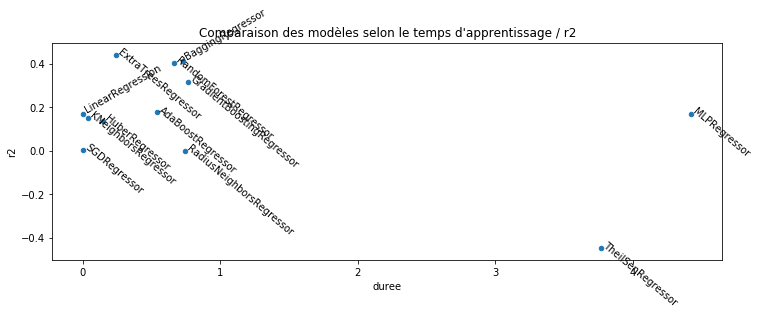

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
df.plot(x='duree', y='r2', kind="scatter", ax=ax)
for row in df.itertuples():
    t, y, x = row[1:4]
    if t[0] in {'B', 'L'}:
        ax.text(x, y, t, rotation=30, ha='left', va='bottom')
    else:
        ax.text(x, y, t, rotation=-40)
ax.set_title("Comparaison des modèles selon le temps d'apprentissage / r2");

L'estimateur [RANSACRegressor](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py) produit un $R^2$ très négatif. Regardons plus en détail.

In [12]:
pred = regressors['RANSACRegressor'].predict(X_test_norm)

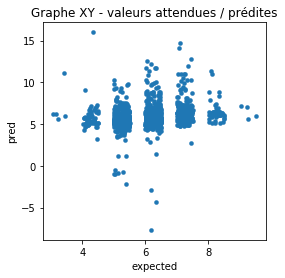

In [13]:
import numpy.random
df = pandas.DataFrame(dict(pred=pred, expected=y_test))
df['expected'] += numpy.random.random(df.shape[0]) * 0.5
ax = df.plot(x="expected", y="pred", kind='scatter', figsize=(4, 4), linewidths=0.1)
ax.set_title('Graphe XY - valeurs attendues / prédites');

Essayons de voir avec la densité.

c:\python370_x64\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\python370_x64\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


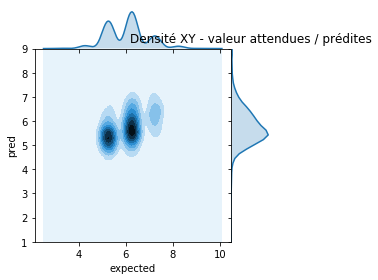

In [14]:
import seaborn
ax = seaborn.jointplot(df["expected"], df["pred"], kind="kde", size=4, space=0, ylim=(1, 9))
ax.ax_marg_y.set_title('Densité XY - valeur attendues / prédites');

Pas facile à voir. Essayons de voir autrement en triant les prédictions et les valeurs attendues par ordre.

In [15]:
sv = df.sort_values(['expected', 'pred']).reset_index(drop=True)

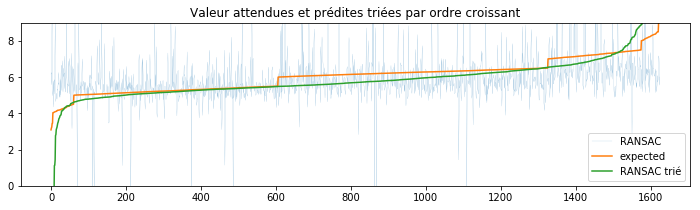

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(sv["pred"], label="RANSAC", lw=0.1)
ax.plot(list(sorted(df["expected"])), label="expected")
ax.plot(list(sorted(df["pred"])), label="RANSAC trié")
ax.set_ylim([0, 9])
ax.set_title('Valeur attendues et prédites triées par ordre croissant')
ax.legend();

Le modèle est plutôt agité.

In [17]:
regressors['RANSACRegressor'].estimator_.intercept_

11.112299910183086

Pour s'assurer que les résultats sont fiables, il faut recommencer avec une validation croisée.

In [18]:
import numpy.random
rnd = numpy.random.permutation(range(X_norm.shape[0]))
xns = X_norm[rnd, :]
yns = yn[rnd]
xns.shape, yns.shape

((6497, 11), (6497,))

In [19]:
from sklearn.model_selection import cross_val_score

def score_model_cross(xn, yn, model):
    res = cross_val_score(model, xn, yn, cv=5)
    return res.mean(), min(res), max(res)

score_model_cross(xns, yns, LinearRegression())

(0.17735962933495708, 0.15156787679271044, 0.22010375789735315)

In [20]:
r2s = []
mis = []
mas = []
names = []
durations = []
regressors = {}
for i, model in enumerate(models):
    if model.__name__ in {'ARDRegression'}:
        continue
    begin = perf_counter()
    reg = model()
    r2, mi, ma = score_model_cross(xns, yns, reg)
    duree = perf_counter() - begin
    r2s.append(r2)
    mis.append(mi)
    mas.append(ma)
    names.append(model.__name__)
    durations.append(duree)
    regressors[model.__name__] = reg
    print(i, model.__name__, r2, mi, ma, duree)

1 HuberRegressor 0.16143773017082763 0.1343542096579915 0.2058969671546783 0.6928935989999978
2 LinearRegression 0.17735962933495708 0.15156787679271044 0.22010375789735315 0.02166397400000264
3 PassiveAggressiveRegressor -2.221306950744386 -3.3374347148258403 -0.908311943524426 0.0405400010000001
4 SGDRegressor 0.005383814726824787 -0.005308444551294755 0.015961202357831605 0.04949603999999752


c:\python370_x64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\python370_x64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\python370_x64\lib\sit

5 TheilSenRegressor -0.31046949798186874 -0.600276919100625 -0.13855264173510462 19.333272493
6 RANSACRegressor -1.969522184582953 -3.5470595453451557 -0.2437848277936332 0.539325385000005
7 RandomForestRegressor 0.44028734843122147 0.4047586446604805 0.502193157549336 3.5825936800000022
8 ExtraTreesRegressor 0.46508067456091834 0.43210136608280764 0.5017346087380682 1.226176522000003
9 BaggingRegressor 0.4229627096590729 0.36635665609892265 0.4718976713139835 3.733942833999997
10 GradientBoostingRegressor 0.3342564969124003 0.314813594989126 0.35647184605405957 3.9815585399999947
11 AdaBoostRegressor 0.19446682407227872 0.17520669402924105 0.2202832961718989 3.4790429880000033
12 KNeighborsRegressor 0.1630092824512183 0.09153152442032564 0.1945381698803167 0.28981694000000857
13 RadiusNeighborsRegressor -0.0013163611922370367 -0.003174891503029631 0.000136329843018701 3.1709441919999932


c:\python370_x64\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\python370_x64\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


14 MLPRegressor 0.19237746284809235 0.15155383341116968 0.22673471951862523 22.347436625


In [21]:
df = pandas.DataFrame(dict(model=names, r2=r2s, min=mis, max=mas, duree=durations))
df = df[['model', 'r2', 'min', 'max', 'duree']]
df.sort_values('r2')

,model,r2,min,max,duree
2,PassiveAggressiveRegressor,-2.221307,-3.337435,-0.908312,0.040540
5,RANSACRegressor,-1.969522,-3.547060,-0.243785,0.539325
4,TheilSenRegressor,-0.310469,-0.600277,-0.138553,19.333272
12,RadiusNeighborsRegressor,-0.001316,-0.003175,0.000136,3.170944
3,SGDRegressor,0.005384,-0.005308,0.015961,0.049496
0,HuberRegressor,0.161438,0.134354,0.205897,0.692894
11,KNeighborsRegressor,0.163009,0.091532,0.194538,0.289817
1,LinearRegression,0.177360,0.151568,0.220104,0.021664
13,MLPRegressor,0.192377,0.151554,0.226735,22.347437
10,AdaBoostRegressor,0.194467,0.175207,0.220283,3.479043


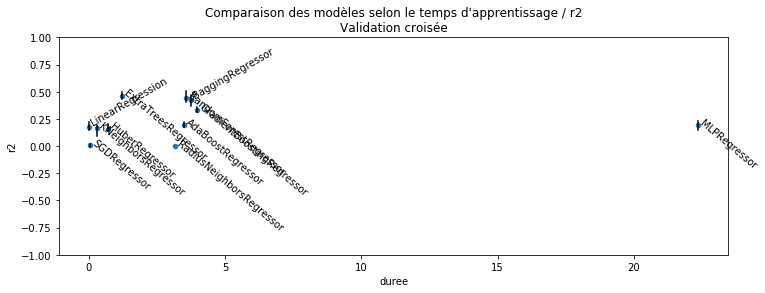

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
df[df['min'] > -0.1].plot(x='duree', y='r2', kind="scatter", ax=ax)
for row in df.itertuples():
    t, y, mi, ma, x = row[1:6]
    if mi < -0.1:
        continue
    ax.plot([x, x], [mi, ma], color="black")
    if t[0] in {'B', 'L'}:
        ax.text(x, y, t, rotation=30, ha='left', va='bottom')
    else:
        ax.text(x, y, t, rotation=-40)
ax.set_ylim([-1, 1])
ax.set_title("Comparaison des modèles selon le temps d'apprentissage / r2\nValidation croisée");

Le modèle [RANSAC](http://scikit-learn.org/stable/modules/linear_model.html#ransac-random-sample-consensus) est conçu pour apprendre un modèle linéaire et réduire l'ensemble d'apprentissage aux points non aberrants. Dans notre cas, vu le peu d'exemples pour les notes élevées, il est très probable que celles-ci disparaissent des observations choisies pour estimer le modèle : le modèle choisit d'évincer les exemples pour lesquels l'erreur est la plus grande en considérant que cela est une indication du fait qu'ils sont aberrants. Malgré cela, sa faible capacité à prévoir vient du fait que la majorité des vins ont une note entre 4 et 6 et que finalement, il y a peu de différences : ils sont tous moyens et la différence s'explique par d'autres facteurs comme le juge ayant donné la note.